# Covid, and Fitbit Health Metrics

## Introduction

Last month (October 2023) my wife and contracted Covid.  We were very late to this party, as we had been diligently
getting all the suggested booster shots. I had had a booster about a fortnight before, but my wife was still in the queue for a booster when she was laid low.

Still, there is no situation so dire that it cannot be turned into an exercise of data visualization.  I wera a Fitbit Versa 3, which collects personal health metrics:

* Breathing rate (BR)

* Heart-rate variability (HRV)

* Skin temperature variation (STV)

* Oxygen saturation (SpO2)

* Resting heart rate (RHR)

I didn't have SpO2 tracking turned on at the time (but I have now).  I thought I would look at how these metrics changed during my recovery from Covid.

One caveat is that after my wife tested positive, I was in denial for a few days ("I've just had a booster, I can't be getting Covid!"), as my symptoms got worse and worse.  So I was very late to self-test with a Rapid Antigen Test (RAT) kit (poking swabs up your nose is not much fun).  Of course it showed a positive result immediately.  So the graphs below that show my test results don't really show the true onset of my Covid infection.

I learned a few more wrinkles in setting up Matplotlib plots with a datetime x axis, and annotating Matplotlib plots.

## Environment

This contains the imports and supporting libraries I used.

### Imports

In [216]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import (
    WeekdayLocator,
    DayLocator,
    SU,
    MO,
    DateFormatter,
    date2num,
)

from pathlib import Path
from datetime import datetime

### Supporting libraries

In [217]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [218]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Dataset

I manually entered the health metric data from my Fitbit App, and created two CSV files.  One (covid1.csv) contained the day-by-day data, the other (ranges.csv) contained what Fitbit considered by normal range for each metric.

Set up the paths to each data file

In [219]:
base = '../data/covid/'

file_1 = 'covid1.csv'
file_2 = 'ranges.csv'

In [220]:
path_base = Path(base)

path_1 = path_base / file_1
path_2 = path_base / file_2

### Data load
We use pandas to read the CSV files into DataFrames

In [221]:
covid_df = pd.read_csv(
    path_1,
)

In [222]:
covid_df.head(2)

,Date,BR,HRV,STV,RHR
0,Sun 8 Oct,14,35,0.6,51
1,Mon 9 Oct,15,34,0.2,52


We check the datatypes for each column.  It looks like the dates have been read as strings

In [223]:
covid_df.dtypes

Date     object
BR        int64
HRV       int64
STV     float64
RHR       int64
dtype: object

In [224]:
covid_df['Date'].head(2)

0    Sun 8 Oct
1    Mon 9 Oct
Name: Date, dtype: object

### Data Cleaning

We define a helper function to transform the initial as-loaded Date column into true pandas datetime values.

In [225]:
def parse_date(df):
    '''
    parse_date: parse a column of date strings in form day-of-week-abb day-of-month month-abb

    function to parse a dataframe column holding strings of dates of form
    Sun 8 Oct

    where the year is assumed to be 2023

    Parameters:
    df: pandas dataframe with column Date_str holding strings as above

    Returns: pandas data series holding dates in datetime64[ns] datatype
    '''
    return [
        datetime.strptime(s + ' 2023', '%a %d %b %Y')
        for s in df.Date_str
    ]


# end parse_date

We:
* rename the Date column to reflect its data type (strings), then

* create new column Date holding parsed date strings as datetime64

In [226]:
covid_df = covid_df.rename(
    columns={'Date': 'Date_str'}
).assign(Date=parse_date)

Check the datatypes - all as expected

In [227]:
covid_df.dtypes

Date_str            object
BR                   int64
HRV                  int64
STV                float64
RHR                  int64
Date        datetime64[ns]
dtype: object

The normal ranges DataFrame doesn't need any more processing

In [228]:
ranges_df = pd.read_csv(
    path_2,
)

In [229]:
ranges_df

,BR,HRV,STV,RHR
0,18,60,2,55
1,10,20,-2,48


## Visualization

The code below started out as one big slab of Matplotlib hacking code, but I refactored out the various operations into standalone functions

### Annotations

I wanted a line plot with a datetime x axis , with key events highlighted on the x axis.
decided to have each significant date to be highlighted by an arrow pointing to the x axis
The first step is to convert the dates of interest into the x values that Matplotlib uses internally.  Matplotlib has a `datetonum` function for this.

I then decided to have an arrow pointing down to the x axis at each key event, with text above.

We use the ylims function to get the range of y axis values shown on the plot.  We use the smallest value as the y value at the tip of the arrow.

The next issue is that while the tip of the arrow needs to be located as a point specified by data values, I want the annotation text to be at a fixed position _relative_ to the tip of the values for each of the plots I am creating (the apparent data y values will change from plot to plot, as the range of each health metric is different.

The code fragment
```
        xytext=(0, 3),
        textcoords='offset fontsize',
```
says place the annotation text with a x offset of 0, and a y offset of 3 times that text font height from the tip of the arrow.

`        ha='right',` says to position the text horizontally so the right end is at the `xytext` coordinates

In [230]:
def annotate_key_dates(
    ax,
) -> None:
    '''
    annotate_key_dates: put annotation on date x axis to show key events

    Parameters:
    ax: matplotlib Axes object

    Returns:
    None

    Side Effects:
    Axes object updated with text annotations


    '''

    # convert dates to values on the x axis (in data units)
    x_contact = date2num(datetime(2023, 10, 14))
    x_severe = date2num(datetime(2023, 10, 22))
    x_rat_positive = date2num(datetime(2023, 10, 23))
    x_rat_neg = date2num(datetime(2023, 10, 29))

    # get the y data coordinate of the x axis
    # this is not zero, as matplotlib only shows the range of y values of interest
    # y_lims[0] is the minimum y value on y axis
    y_lims = ax.get_ylim()

    ax.annotate(
        'Contact Event (Wife)',
        (x_contact, y_lims[0]),
        xytext=(0, 3),
        textcoords='offset fontsize',
        ha='right',
        arrowprops=dict(
            facecolor='black', shrink=0.05, alpha=0.5
        ),
    )

    ax.annotate(
        'Severe Symptoms (Wife)',
        (x_severe, y_lims[0]),
        xytext=(0, 3),
        textcoords='offset fontsize',
        ha='right',
        arrowprops=dict(
            facecolor='black', shrink=0.05, alpha=0.5
        ),
    )

    ax.annotate(
        '+ve RAT Test',
        (x_rat_positive, y_lims[0]),
        xytext=(0, 3),
        textcoords='offset fontsize',
        ha='left',
        arrowprops=dict(
            facecolor='black', shrink=0.05, alpha=0.5
        ),
    )

    ax.annotate(
        '-ve RAT Test',
        (x_rat_neg, y_lims[0]),
        xytext=(0, 3),
        textcoords='offset fontsize',
        ha='left',
        arrowprops=dict(
            facecolor='black', shrink=0.05, alpha=0.5
        ),
    )

    return None


# end annotate_key_dates

### X axis formatting

We want a day by by plot of health metrics, but don't need every day labelled.  We choose to label the Monday at the start of each week, via the
`set_major_locator( WeekdayLocator(byweekday=MO, interval=1),)` call.  

The other days will have grid lines drawn, as set by the `set_minor_locator(DayLocator(interval=1))` call

We choose to have the start of week grid lines darker than the other grid 
lines

In [231]:
def set_month_xaxis(ax) -> None:
    '''
    set_month_xaxis: set up xaxis to show a month duration

    We set start of week as Monday, show start of week in labels, and
    set up a grid showing days in month (no labels)

    Parameters:
    ax: matplotlib Axes object

    Returns:
    None

    Side Effects:
    Axes x axis tick and tick labels set up to show day in month
    '''
    ax.xaxis.set_major_locator(
        WeekdayLocator(byweekday=MO, interval=1),
    )
    ax.xaxis.set_major_formatter(DateFormatter('%d %b'))

    ax.xaxis.set_minor_locator(DayLocator(interval=1))

    ax.grid(axis='both', which='minor', alpha=0.5)
    ax.grid(axis='both', which='major', alpha=1.0)

    return None


# end set_month_xaxis

### Showing normal ranges

Given the metric code, we retrieve the upper and lower normal range, and draw horizontal lines.  The lines are given a label so we can use the legend to explain their purpose

I eventually decided to have red for upper range, green for lower range.  I am not totally happy about this, because it signals that exceeding the upper range is a warning (which might not be the case).  However, I needed some way to tie the legend text to each line, and color seemed the best.

In [232]:
def show_normal_range(
    ax, ranges_df: pd.DataFrame, metric_code: str
) -> None:
    '''
    show_normal_range: show on plot the normal range for a health metric

    Parameters:
    ax: matplotlib Axes object

    ranges_df: pandas Dataframe of form
            BR	HRV	STV	RHR
        0	18	60	2	55
        1	10	20	-2	48

    metric_code: string, being one of BR, HRV, STV, RHR

    Returns:
    None

    Side Effects:
    draw horizontal line on plot
    '''
    ax.axhline(
        y=ranges_df.loc[0, metric_code],
        color='red',
        zorder=0,
        label='Normal Range High',
    )
    ax.axhline(
        y=ranges_df.loc[1, metric_code],
        color='green',
        zorder=0,
        label='Normal Range Low',
    )

    ax.axhspan(
        ranges_df.loc[1, metric_code],
        ranges_df.loc[0, metric_code],
        facecolor='gray',
        alpha=0.1,
        label='Normal Range',
    )
    return None


# end show_normal_range

### Finished graphic

We:
* use Seaborn to create a lineplot, 
* set a title, 
* show the normal ranges, 
* set up the x axis, 
* annotate the key dates
* suppress the x axis label (it is clear it is a date axis)
* create a legend

In [233]:
def plot_health_metric(
    ax,
    covid_df: pd.DataFrame,
    ranges_df: pd.DataFrame,
    metric_code: str,
    metric_title: str,
) -> None:
    '''
    plot_health_metric: show a line graph of a health metric, and its normal range, in a matplotlib Axes object

    Parameters
    ax: matplotlib Axes object

    covid_df: pandas DataFrame holding health metric data for period of interest

    ranges_df: pandas DataFrame hold normal ranges for each health metric

    metric_code: string being a column name in covid_df

    metric_title: string, to be use in plot title

    '''
    sns.lineplot(
        data=covid_df,
        x='Date',
        y=metric_code,
        marker='o',
        ax=ax,
    )

    ax.set_title(metric_title + ' (' + metric_code + ')')

    show_normal_range(ax, ranges_df, metric_code)

    set_month_xaxis(ax)

    annotate_key_dates(
        ax,
    )

    # suppress x axis label
    ax.set_xlabel('')

    # show legend
    ax.legend(loc='upper left')


# end plot_health_metric

### Produce sample graphic

I prefer the Seaborn `whitegrid` style

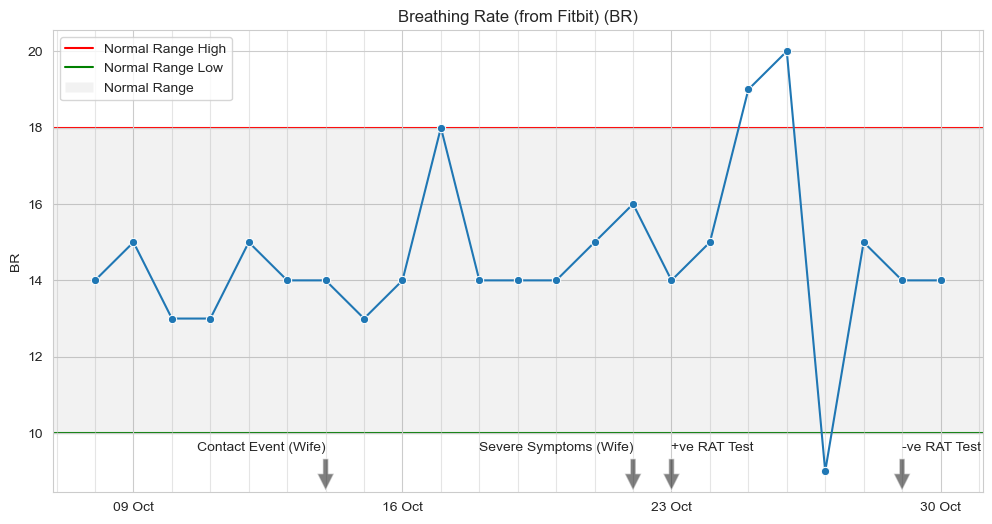

In [234]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

plot_health_metric(
    ax,
    covid_df,
    ranges_df,
    'BR',
    'Breathing Rate (from Fitbit)',
)

## All metrics graphics

We now do all four health metrics, in a column.  It is clear that each metric reaches or exceeds my normal range in the period I was Covid positive.

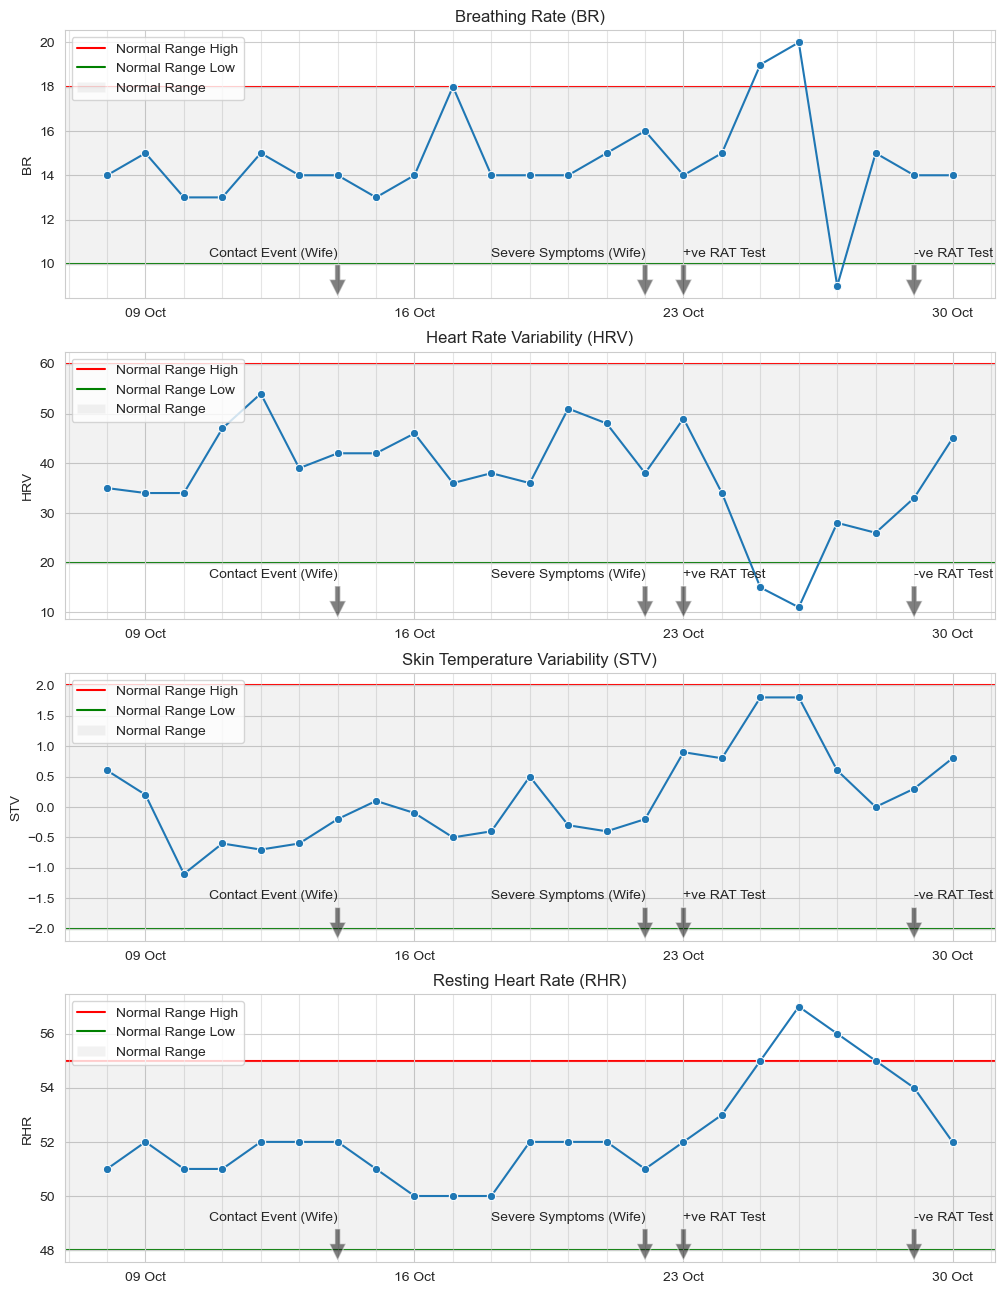

In [235]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(figsize=(12, 16), nrows=4, ncols=1)

codes = ['BR', 'HRV', 'STV', 'RHR']
titles = [
    'Breathing Rate',
    'Heart Rate Variability',
    'Skin Temperature Variability',
    'Resting Heart Rate',
]


for ax, code, title in zip(axes, codes, titles):
    plot_health_metric(
        ax,
        covid_df,
        ranges_df,
        code,
        title,
    )
# end for

## Combined plot

Finally a combined plot, where we scale each health metric to 0 - 100, corresponding the normal range

In [236]:
RANGE_HI = 0
RANGE_LO = 1

for c in codes:
    covid_df[c + '_Scaled'] = (
        (covid_df[c] - ranges_df.loc[RANGE_LO, c])
        / (
            ranges_df.loc[RANGE_HI, c]
            - ranges_df.loc[RANGE_LO, c]
        )
        * 100.0
    )
# end for

In [237]:
covid_df.head(4)

,Date_str,BR,HRV,STV,RHR,Date,BR_Scaled,HRV_Scaled,STV_Scaled,RHR_Scaled
0,Sun 8 Oct,14,35,0.6,51,2023-10-08,50.0,37.5,65.0,42.857143
1,Mon 9 Oct,15,34,0.2,52,2023-10-09,62.5,35.0,55.0,57.142857
2,Tue 10 Oct,13,34,-1.1,51,2023-10-10,37.5,35.0,22.5,42.857143
3,Wed 11 Oct,13,47,-0.6,51,2023-10-11,37.5,67.5,35.0,42.857143


We loop, for each metric code, get the scaled data, and overlay a line plot onto the one Matplotlib Axes object

Text(0.5, 1.0, 'Combined Fitbit Health Metrics (scaled)')

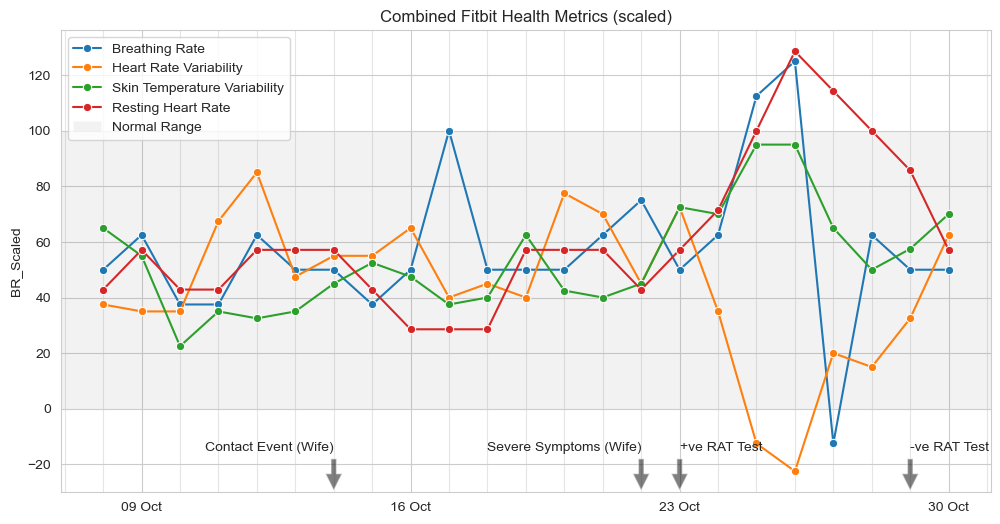

In [238]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

markers = ['o'] * 4

for marker, code, title in zip(markers, codes, titles):
    sns.lineplot(
        data=covid_df,
        x='Date',
        y=code + '_Scaled',
        marker=marker,
        ax=ax,
        label=title,
    )
# end for

set_month_xaxis(ax)

annotate_key_dates(
    ax,
)

# hide x axis label
ax.set_xlabel('')

# show normal range
ax.axhspan(
    0,
    100,
    facecolor='gray',
    alpha=0.1,
    label='Normal Range',
)

# show legend
ax.legend(loc='upper left')

ax.set_title('Combined Fitbit Health Metrics (scaled)')

## Conclusion

It is clear that during my bout of Covid, there some something extreme going on with my body metabolism.  I have absolutely __no__ wish to repeat this experiment!

## Execution Environment

In [239]:
%watermark

Last updated: 2023-11-24T14:21:26.649851+10:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [240]:
%watermark -co -iv

conda environment: base

matplotlib: 3.5.2
pandas    : 1.4.4
seaborn   : 0.11.2

